# review_scores_rating prediction

In [25]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plot
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import seaborn as sns
import warnings


In [26]:
df = pd.read_pickle("./cleaned_data.pkl")

## A peek inside dataset

In [27]:
df.head()

,date,comments,last_scraped,source,name,description,neighborhood_overview,host_since,host_location,host_about,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2011-03-20,87573,2022-09-12,0,6027,3590,792,2010-08-06,132,857,...,4.93,4.93,4.66,4.82,0,2,0,2,0,1.85
1,2011-03-28,90870,2022-09-12,0,6027,3590,792,2010-08-06,132,857,...,4.93,4.93,4.66,4.82,0,2,0,2,0,1.85
2,2011-04-21,70322,2022-09-12,0,6027,3590,792,2010-08-06,132,857,...,4.93,4.93,4.66,4.82,0,2,0,2,0,1.85
3,2011-05-13,57652,2022-09-12,0,6027,3590,792,2010-08-06,132,857,...,4.93,4.93,4.66,4.82,0,2,0,2,0,1.85
4,2011-05-17,70441,2022-09-12,0,6027,3590,792,2010-08-06,132,857,...,4.93,4.93,4.66,4.82,0,2,0,2,0,1.85


## distribution of review_score_rating

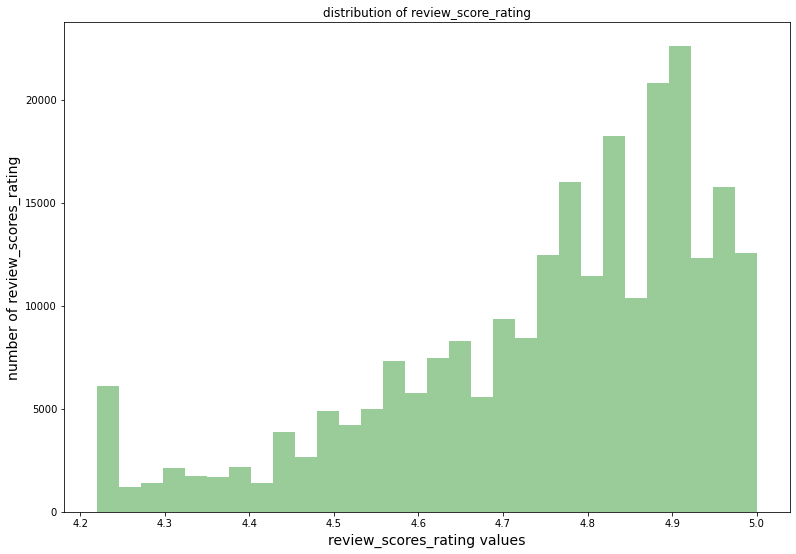

In [28]:
warnings.filterwarnings('ignore')
df['review_scores_rating'].loc[df['review_scores_rating']>np.percentile(df['review_scores_rating'].values, 98)] = np.percentile(df['review_scores_rating'].values, 98)
df['review_scores_rating'].loc[df['review_scores_rating']<np.percentile(df['review_scores_rating'].values, 2)] = np.percentile(df['review_scores_rating'], 2)

plot.figure(figsize=(13,9))
sns.distplot(df.review_scores_rating.values,kde=False,color='green', bins=30)
plot.xlabel('review_scores_rating values', fontsize=14)
plot.ylabel('number of review_scores_rating', fontsize=14)
plot.title("distribution of review_score_rating")
plot.savefig('dis_val.png', facecolor='w', transparent=False)
plot.show()

## review_score_rating

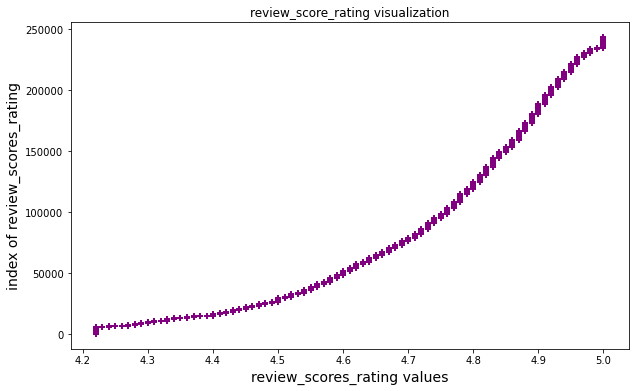

In [29]:
plot.figure(figsize=(10,6))
x, y = pd.Series(np.sort(df['review_scores_rating'].values), name="review_scores_rating"), pd.Series(range(len(df['review_scores_rating'])), name="index of review_scores_rating values")
sns.regplot(x=x, y=y, marker="+",fit_reg=False,color='purple')
plot.title("review_score_rating visualization")
plot.xlabel('review_scores_rating values', fontsize=14)
plot.ylabel('index of review_scores_rating', fontsize=14)
plot.savefig('vis_val.png', facecolor='w', transparent=False)
plot.show()

## datetime to float

In [30]:
#fit datetime to standard scaler
df['date']=df['date'].values.astype("float64")
df['last_scraped']=df['last_scraped'].values.astype("float64")
df['host_since'] = df['host_since'].values.astype("float64")
df['calendar_last_scraped']=df['calendar_last_scraped'].values.astype("float64")
df['first_review']=df[('first_review')].values.astype("float64") 
df['last_review']=df[('last_review')].values.astype("float64")

## standardize data with StandardScalar

In [31]:
column_keys = df.keys()
scaler = StandardScaler()
review_scores_rating = df.pop('review_scores_rating')

df = scaler.fit_transform(df)

df = pd.DataFrame(np.column_stack((df, review_scores_rating)), columns=column_keys)
df = df.sample(frac=1).reset_index(drop=True)

## correlation between features and review_scores_rating

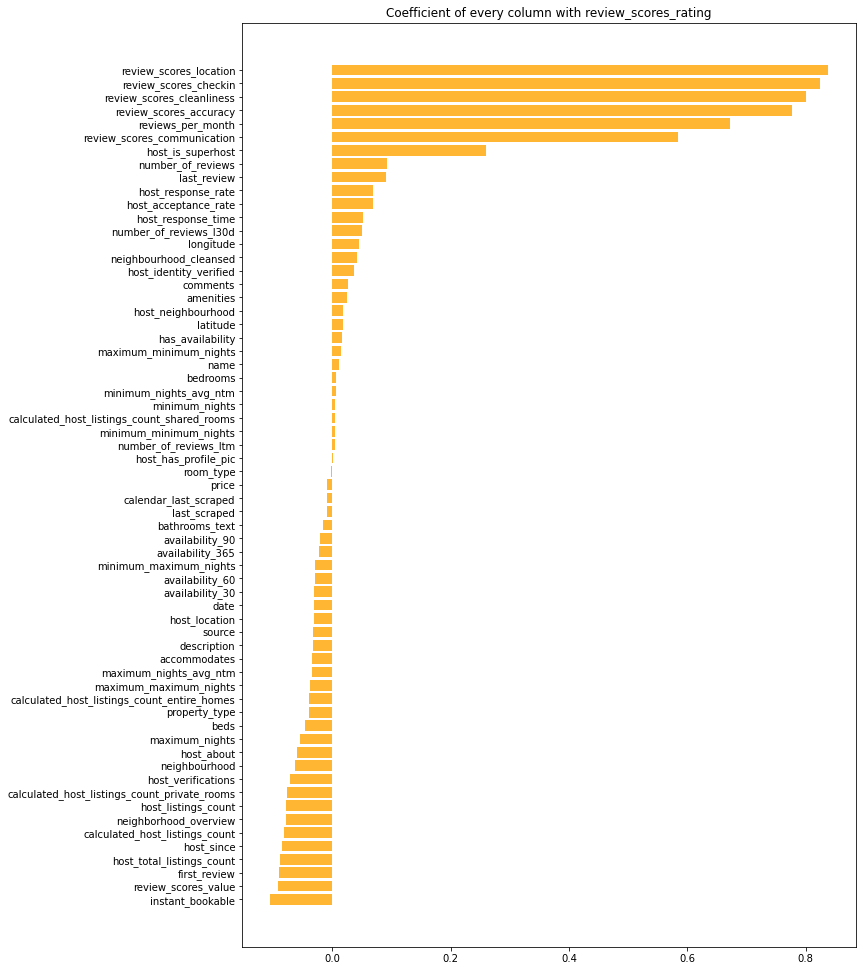

In [32]:

columns = [col for col in df.columns 
           if col not in ['review_scores_rating'] ]
lbls = [] 
vals = []
for column in columns:
    lbls.append(column)
    vals.append(np.corrcoef(df[column].values, df['review_scores_rating'].values)[0,1])

correlation_data = pd.DataFrame({'lbls':lbls, 'vals':vals})
correlation_data = correlation_data.sort_values(by='vals')
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(correlation_data.shape[0]), correlation_data.vals.values, alpha=0.8,color='orange')
axes.set_title("Coefficient of every column with review_scores_rating")
axes.set_yticks(np.arange(correlation_data.shape[0]))
axes.set_yticklabels(correlation_data.lbls.values, rotation='horizontal')
plt.xlabel('coefficients', fontsize=10)
plot.savefig('corr_val1.png', facecolor='w', transparent=False)
plot.show()

## feature of importance linear(lasso) regression

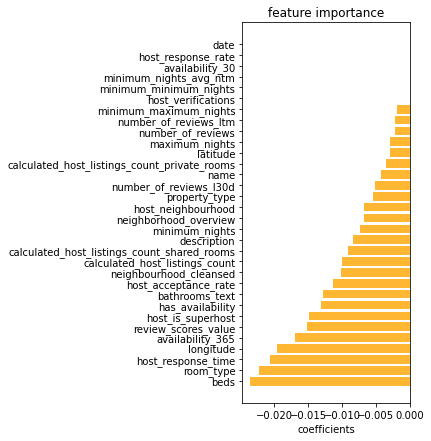

In [40]:
# define dataset
y = df['review_scores_rating']
X = df.drop(['review_scores_rating'], axis=1)
# define the model
model = LassoCV(cv=5)
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_


feas = pd.DataFrame()
feas['features'] = X.keys()
feas['importance'] = importance
feas = feas.sort_values(by='importance')


feas1 = feas[0:32]
feas2 = feas[32:64]

plot.rc('font', size=10);
fig, axes = plot.subplots(figsize=(3,7))
axes.barh(np.arange(feas1.shape[0]), feas1.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas1.shape[0]))
axes.set_yticklabels(feas1.features.values, rotation='horizontal')
plot.xlabel('coefficients', fontsize=10)
plot.savefig('las_val1.png', facecolor='w', transparent=False)

plot.show()

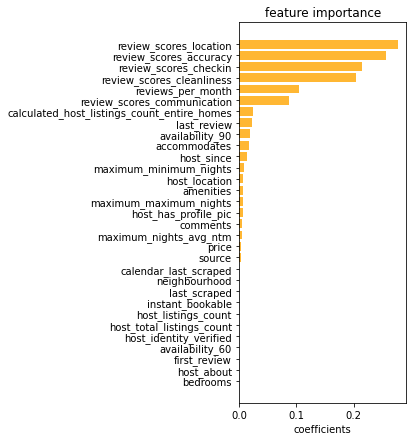

In [41]:
fig, axes = plot.subplots(figsize=(3,7))
axes.barh(np.arange(feas2.shape[0]), feas2.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas2.shape[0]))
axes.set_yticklabels(feas2.features.values, rotation='horizontal')
plot.xlabel('coefficients', fontsize=10)
plot.savefig('las_val2.png', facecolor='w', transparent=False)
plot.show()

## feature importance ridge regression

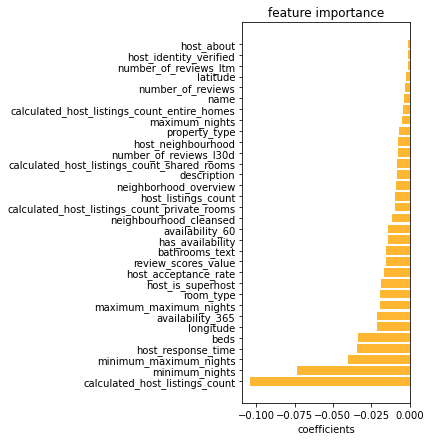

In [43]:
# define dataset
y = df['review_scores_rating']
X = df.drop(['review_scores_rating'], axis=1)
# define the model
model = RidgeCV(cv=5)
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_


feas = pd.DataFrame()
feas['features'] = X.keys()
feas['importance'] = importance
feas = feas.sort_values(by='importance')


feas3 = feas[0:32]
feas4 = feas[32:64]

plot.rc('font', size=10);
fig, axes = plot.subplots(figsize=(3,7))
axes.barh(np.arange(feas3.shape[0]), feas3.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas3.shape[0]))
axes.set_yticklabels(feas3.features.values, rotation='horizontal')
plot.xlabel('coefficients', fontsize=10)
plot.savefig('rig_val1.png', facecolor='w', transparent=False)

plot.show()

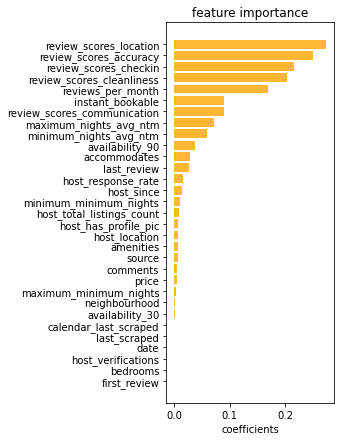

In [42]:
fig, axes = plot.subplots(figsize=(3,7))
axes.barh(np.arange(feas4.shape[0]), feas4.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas4.shape[0]))
axes.set_yticklabels(feas4.features.values, rotation='horizontal')
plot.xlabel('coefficients', fontsize=10)
plot.savefig('rig_val2.png', facecolor='w', transparent=False)
plot.show()

In [13]:
feas_neg=feas1.head(6)
neg = feas_neg['features'].values.tolist()
feas_pos=feas2.tail(6)
pos = feas_pos['features'].values.tolist()

## feature selection and train test split

In [14]:
y = df['review_scores_rating']
X = df[neg+pos]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,stratify=y)

## baseline model

In [15]:
dummy = DummyRegressor(strategy='mean').fit(Xtrain, ytrain)
ydummy = dummy.predict(Xtest)
mean_squared_error(ytest, ydummy)

1.0032252024412798

In [16]:
dummy_r2 = r2_score(y_true=ytest, y_pred=ydummy)
print(dummy_r2)

-2.6262740870919288e-09


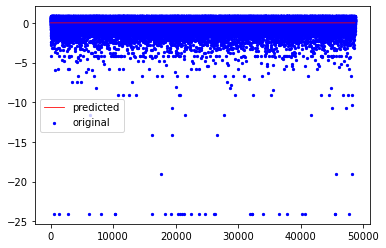

In [50]:
x_ax = range(len(ytest))
plot.scatter(x_ax, ytest, s=5, color="blue", label="original")
plot.plot(x_ax, ydummy, lw=0.8, color="red", label="predicted")
plot.legend()
plot.show()

## lasso 5-fold cross validation

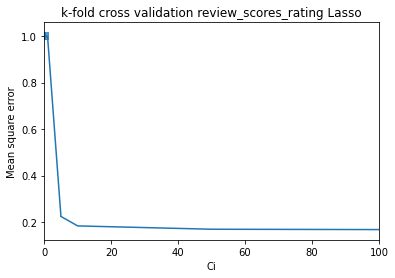

In [17]:

mean_error = []
std_error = []
C_range = [0.1, 0.5, 1, 5, 10, 50, 100]
for C in C_range:
    model = Lasso(alpha=1/C)
    temp = []
    kf = KFold(n_splits=5)
    for train, test in kf.split(Xtrain, ytrain):

        model.fit(Xtrain.iloc[train], ytrain.iloc[train])
        ypred = model.predict(Xtrain.iloc[train])
        temp.append(mean_squared_error(ytrain.iloc[train], ypred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
plot.errorbar(C_range, mean_error, yerr=std_error)
plot.xlabel("Ci")
plot.ylabel("Mean square error")
plot.title("k-fold cross validation review_scores_rating Lasso")
plot.xlim((0, 100))
plot.savefig('lasCV_val.png', facecolor='w', transparent=False)
plot.show()

## lasso MSE and R^2 

In [46]:
model1 = Lasso(alpha=1/10).fit(Xtrain,ytrain)
y_pred = model1.predict(Xtest)
mean_squared_error(ytest, y_pred)

0.19526597579738594

In [47]:
las_r2 = r2_score(y_true=ytest, y_pred=y_pred)
print(las_r2)

0.805361771379904


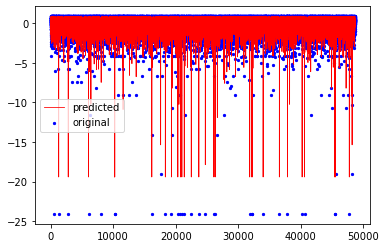

In [49]:
x_ax = range(len(ytest))
plot.scatter(x_ax, ytest, s=5, color="blue", label="original")
plot.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plot.legend()
plot.show()

## ridge 5-fold cross validation

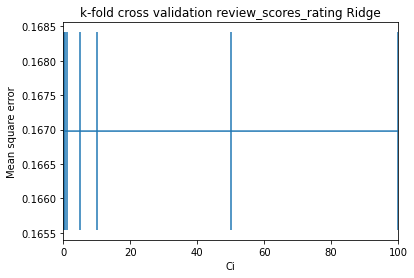

In [20]:
mean_error = []
std_error = []
C_range = [0.1, 0.5, 1, 5, 10, 50, 100]
for C in C_range:
    model = Ridge(alpha=1/C)
    temp = []
    kf = KFold(n_splits=5)
    for train, test in kf.split(Xtrain, ytrain):

        model.fit(Xtrain.iloc[train], ytrain.iloc[train])
        ypred = model.predict(Xtrain.iloc[train])
        temp.append(mean_squared_error(ytrain.iloc[train], ypred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
plot.errorbar(C_range, mean_error, yerr=std_error)
plot.xlabel("Ci")
plot.ylabel("Mean square error")
plot.title("k-fold cross validation review_scores_rating Ridge")
plot.xlim((0, 100))
plot.savefig('rigCV_val.png', facecolor='w', transparent=False)
plot.show()

## ridge MSE and R^2

In [21]:

model2 = Ridge(alpha=1).fit(Xtrain,ytrain)
y_pred1 = model2.predict(Xtest)
mean_squared_error(ytest, y_pred1)

0.17934577267373517

In [22]:
ridge_r2 = r2_score(y_true=ytest, y_pred=y_pred1)
print(ridge_r2)

0.8212307937357229


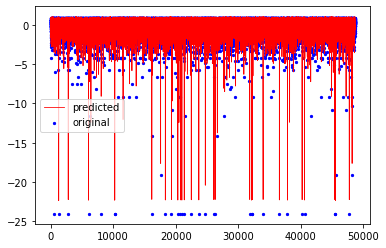

In [48]:
x_ax = range(len(ytest))
plot.scatter(x_ax, ytest, s=5, color="blue", label="original")
plot.plot(x_ax, y_pred1, lw=0.8, color="red", label="predicted")
plot.legend()
plot.show()